In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns
from tqdm import tqdm

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import data_quality_checks

In [4]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
company_df = pd.read_csv('all_retailer_company.csv',index_col = 0)
company_df.columns = ['company_name','company_identifier','state','licenses']
company_df['company_identifier'] = company_df['company_identifier'].astype(str)

In [6]:
company_df_clean = company_df[~company_df['company_identifier'].isin(['PL','WHT','GF','UR'])]
company_df.shape

(66, 4)

In [7]:
len(company_df['company_identifier'].unique())

66

In [8]:
company_df

,company_name,company_identifier,state,licenses
0,99 High Tide,99HT,CA,C10-0000279-LIC
1,Altum LLC,ALT,MI,PC-000310;AU-R-000380
2,Bella Sol,BS,MI,PC-000185;AU-R-000156
3,Big Medicine Cannabissary,BMC,CO,402-00930
4,Boston Bud Factory,BBF,MA,MR281525
...,...,...,...,...
61,Universal Herbal Health Center,UHHC,CA,C10-0000817-LIC;C9-0000082-LIC
62,Uprooted (San Ysidro),UR,CA,C10-0000731-LIC;C10-0000776-LIC;C10-0000246-LI...
63,Verts,VS,CO,402-00840;402R-00545
64,Voyage,VOY,CA,C12-0000030-LIC;C10-0000802-LIC;C12-0000159-LIC


In [9]:
company_df['lic_list'] = [list(company_df['licenses'])[i].split(";") for i in range(len(company_df))]

In [10]:
len(company_df['company_identifier'].unique())

66

In [11]:
company_df[company_df['company_identifier'] == 'ST']

,company_name,company_identifier,state,licenses,lic_list
53,Sticky Thumb,ST,CA,C9-0000323-LIC,[C9-0000323-LIC]


# vc

In [12]:
# as of data of 3/2022
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2021-12-01','2022-01-01','2022-02-01','2022-03-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [13]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    # cast any purchase under $ 100 to be 0
    #indices = vc_full[vc_full['shipper_wholesale_price'] < 100].index.to_list()
    #vc_full.loc[indices,'shipper_wholesale_price'] = 0
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix


In [14]:
def calculate_vendor_churn_short(incoming_transfer_df,license_list,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    # cast any purchase under $ 100 to be 0
    indices = vc_full[vc_full['shipper_wholesale_price'] < 100].index.to_list()
    vc_full.loc[indices,'shipper_wholesale_price'] = 0
    
    #rolling_4m_sum
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    
    #facility_monthly_running_total
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].rolling(window = 12).sum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    
    #monthly_running_total
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.iloc[: , -12:].sum(axis = 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[vc_month_list].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


In [ ]:
## test

In [145]:
#bad example of small number mess up whole vc%
# to do: impose minimal amount to the vc matrix
df_in_test,df_sales_deduped_test,bad_dl_test,unknown_transfer_test,rwp_test,miss_incoming_test,miss_receipts_test = data_quality_checks.run(['KC'],TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE)




Verifying download summaries for license 402-00037...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 402-00323...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 402-00573...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 402-00664...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 402-01146...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 403-00853...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 403-01756...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-25

Verifying download summaries for license 404-00509...
Earliest download summary: 2020-01-01
Lates

In [150]:
lic_test = df_in_test['license_number'].unique()[8]
lic_test


'402-00573'

In [151]:
a_short,b_short = calculate_vendor_churn_short(df_in_test,[lic_test],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)

a,b = calculate_vendor_churn(df_in_test,[lic_test],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)





In [ ]:
a_short,b_short = calculate_vendor_churn_short(df_in_test,list(lic_test),VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)

a,b = calculate_vendor_churn(df_in_test,list(lic_test),VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)





In [152]:
#c,vc,a,b = calculate_vendor_churn(df_in,[lic],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
b_short


year_month,shipper_facility_name,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure
0,BCC LLC,0.00,0.00,4500.00,0.0,0.0,0.0,1260.0,0.00,4500,0.00,0.0,46408.76,0.00,0.00,4846.03,7350,8950.0,6710.00,0.0,1330.00,1430.0,1500.00,1304,18699.04,2400.00,1440,0,51113.04,331546.73,0.154165,22539.04,True,True,Active
1,BIG TOP LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,1485.00,0.0,0.00,0,0.00,0.00,0,0,1485.00,331546.73,0.004479,0.00,False,True,Inactive
2,CAREGIVERS FOR LIFE LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
3,CLEARVIEW INDUSTRIES LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,1377.50,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,1377.50,331546.73,0.004155,0.00,False,True,Inactive
4,COLD BAKED LLC,0.00,0.00,0.00,0.0,1700.5,3000.0,0.0,6600.00,2420,0.00,2200.0,2640.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
5,CONNOISSEURS GENETICS & CONCENTRATES LLC,0.00,2520.00,1120.00,3441.2,2184.0,3490.2,3100.0,650.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
6,D & D CONSULTING INC,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
7,DABBINGTON LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
8,DABS LABS LLC,0.00,0.00,306.00,0.0,0.0,0.0,0.0,0.00,0,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.0,0.00,0.0,0.00,0,0.00,0.00,0,0,0.00,331546.73,0.000000,0.00,False,False,Exclude
9,DENVER PACKAGING COMPANY,0.00,810.00,810.00,0.0,1098.0,936.0,780.0,900.00,2658,810.00,552.0,1944.00,1458.00,0.00,0.00,2610,0.0,900.00,1032.0,1398.00,0.0,2556.00,0,0.00,0.00,0,0,8496.00,331546.73,0.025625,0.00,False,True,Inactive


In [153]:
b

year_month,shipper_facility_name,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure
0,BCC LLC,0.00,0.00,4500.00,0.0,0.0,0.0,1260.00,0.00,4500.00,0.00,0.0,46408.76,0.25,0.00,4846.03,7350,8950.0,6710.00,0.00,1330.00,1430.00,1500.00,1304.00,18699.04,2400.00,1440.0,0,112628.08,1051716.94,1.070897e-01,22539.04,True,True,Active
1,BIG TOP LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,1485.00,0.00,0.00,0.00,0.00,0.00,0.0,0,1485.00,1051716.94,1.411977e-03,0.00,False,True,Inactive
2,CAREGIVERS FOR LIFE LLC,2.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,2.00,1051716.94,1.901652e-06,0.00,False,False,Exclude
3,CLEARVIEW INDUSTRIES LLC,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.03,0,0.0,1377.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,1377.53,1051716.94,1.309792e-03,0.00,False,True,Inactive
4,COLD BAKED LLC,0.00,0.00,0.00,0.0,1700.5,3000.0,0.00,6600.00,2420.00,0.00,2200.0,2640.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,18560.50,1051716.94,1.764781e-02,0.00,False,True,Inactive
5,CONNOISSEURS GENETICS & CONCENTRATES LLC,0.40,2520.00,1120.00,3441.2,2184.0,3490.2,3100.00,650.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,16505.80,1051716.94,1.569415e-02,0.00,False,True,Inactive
6,D & D CONSULTING INC,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0.00,1051716.94,0.000000e+00,0.00,False,False,Exclude
7,DABBINGTON LLC,0.00,0.00,0.00,0.0,0.0,0.0,2.76,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,2.76,1051716.94,2.624280e-06,0.00,False,False,Exclude
8,DABS LABS LLC,0.00,0.00,306.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,306.00,1051716.94,2.909528e-04,0.00,False,False,Exclude
9,DENVER PACKAGING COMPANY,0.00,810.00,810.00,0.0,1098.0,936.0,780.00,900.00,2658.00,810.00,552.0,1944.00,1458.00,0.00,0.00,2610,0.0,900.00,1032.00,1398.00,0.00,2556.00,0.00,0.00,0.00,0.0,0,21252.00,1051716.94,2.020696e-02,0.00,False,True,Inactive


# run

In [15]:
def read_df_in(COMPANY_IDENTIFIER,license_numbers):
    company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
    )
    company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
    return company_incoming_transfer_packages_dataframe


In [16]:
def get_vc_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,map_df):
    churn_df_list = {}
    vc_matrix_df_list = {}
    churn_df_list_short = {}
    vc_matrix_df_list_short = {}
    for c in tqdm(company_list):
        churn_list = {}
        vc_matrix_list = {}
        churn_list_short = {}
        vc_matrix_list_short = {}
        print(c)
        l_list = map_df[map_df['company_identifier'] == c]['lic_list'].to_list()[0]
        for l in tqdm(l_list):
            print(l)
            df_in = read_df_in([c],[l])
            if df_in.shape[0] == 0:
                churn_list[l] = numpy.nan
                vc_matrix_list[l] = numpy.nan
                churn_list_short[l] = numpy.nan
                vc_matrix_list_short[l] = numpy.nan
                continue
            else:
                churn,vc_matrix = calculate_vendor_churn(df_in,[l],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
                churn_short,vc_matrix_short = calculate_vendor_churn_short(df_in,[l],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
                churn_list[l] = churn
                vc_matrix_list[l] = vc_matrix
                churn_list_short[l] = churn_short
                vc_matrix_list_short[l] = vc_matrix_short
        churn_df_list[c] = churn_list
        vc_matrix_df_list[c] = vc_matrix_list
        churn_df_list_short[c] = churn_list_short
        vc_matrix_df_list_short[c] = vc_matrix_list_short
    return churn_df_list,vc_matrix_df_list,churn_df_list_short,vc_matrix_df_list_short

    

    

In [17]:
c,vc,c_short,vc_short = get_vc_list(list(company_df['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,company_df)




  0%|          | 0/66 [00:00<?, ?it/s]

99HT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/66 [00:04<04:50,  4.47s/it]

ALT



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000310



 50%|█████     | 1/2 [00:02<00:02,  2.57s/it]

AU-R-000380



  3%|▎         | 2/66 [00:10<05:44,  5.38s/it]

BS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000185



 50%|█████     | 1/2 [00:03<00:03,  3.33s/it]

AU-R-000156



  5%|▍         | 3/66 [00:17<06:20,  6.04s/it]

BMC



  0%|          | 0/1 [00:00<?, ?it/s]

402-00930



  6%|▌         | 4/66 [00:20<05:08,  4.98s/it]

BBF



  0%|          | 0/1 [00:00<?, ?it/s]

MR281525



  8%|▊         | 5/66 [00:23<04:24,  4.33s/it]

BUD



  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:03<00:13,  3.45s/it]

C9-0000467-LIC



 40%|████      | 2/5 [00:06<00:09,  3.26s/it]

C9-0000444-LIC



 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

C9-0000167-LIC



 80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

C9-0000399-LIC



  9%|▉         | 6/66 [00:40<08:31,  8.53s/it]

CHO



  0%|          | 0/1 [00:00<?, ?it/s]

AU-R-000575



 11%|█         | 7/66 [00:43<06:41,  6.81s/it]

CG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000157-LIC



 12%|█▏        | 8/66 [00:47<05:36,  5.80s/it]

CPA



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:05<00:05,  5.12s/it]

C9-0000348-LIC



 14%|█▎        | 9/66 [00:56<06:28,  6.82s/it]

CPC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 15%|█▌        | 10/66 [00:59<05:18,  5.68s/it]

CSC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.59s/it]

C10-0000918-LIC



 17%|█▋        | 11/66 [01:07<05:55,  6.47s/it]

CCC



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 18%|█▊        | 12/66 [01:12<05:17,  5.88s/it]

CC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 20%|█▉        | 13/66 [01:15<04:32,  5.15s/it]

DWF



  0%|          | 0/1 [00:00<?, ?it/s]

402R-00804



 21%|██        | 14/66 [01:19<04:00,  4.63s/it]

DCO



  0%|          | 0/2 [00:00<?, ?it/s]

050-10052885D4C



 50%|█████     | 1/2 [00:04<00:04,  4.75s/it]

050-10070593E9E



 23%|██▎       | 15/66 [01:28<05:01,  5.91s/it]

DL



  0%|          | 0/1 [00:00<?, ?it/s]

MR283369



 24%|██▍       | 16/66 [01:31<04:13,  5.08s/it]

DGG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 26%|██▌       | 17/66 [01:34<03:43,  4.55s/it]

DG



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000485



 17%|█▋        | 1/6 [00:02<00:10,  2.18s/it]

AU-R-000287



 33%|███▎      | 2/6 [00:06<00:12,  3.21s/it]

AU-R-000359



 50%|█████     | 3/6 [00:10<00:10,  3.56s/it]

AU-R-000422



 67%|██████▋   | 4/6 [00:13<00:06,  3.47s/it]

AU-R-000470



 83%|████████▎ | 5/6 [00:16<00:03,  3.31s/it]

AU-R-000572



 27%|██▋       | 18/66 [01:54<07:12,  9.02s/it]

EL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000370-LIC



 29%|██▉       | 19/66 [01:57<05:41,  7.26s/it]

EMA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 30%|███       | 20/66 [02:01<04:45,  6.21s/it]

EMF



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000939-LIC



 32%|███▏      | 21/66 [02:04<04:00,  5.35s/it]

EMM



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 33%|███▎      | 22/66 [02:08<03:36,  4.91s/it]

EMT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 35%|███▍      | 23/66 [02:12<03:21,  4.69s/it]

EH



  0%|          | 0/1 [00:00<?, ?it/s]

MR283073



 36%|███▋      | 24/66 [02:14<02:48,  4.01s/it]

FW



  0%|          | 0/5 [00:00<?, ?it/s]

402-00558



 20%|██        | 1/5 [00:03<00:13,  3.46s/it]

402R-00017



 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

402-00891



 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

402R-00020



 80%|████████  | 4/5 [00:16<00:04,  4.45s/it]

402R-00747



 38%|███▊      | 25/66 [02:35<06:11,  9.05s/it]

GT



  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.88s/it]

C9-0000170-LIC



 39%|███▉      | 26/66 [02:41<05:27,  8.18s/it]

GLNR



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000334



 17%|█▋        | 1/6 [00:02<00:12,  2.42s/it]

PC-000613



 33%|███▎      | 2/6 [00:04<00:09,  2.40s/it]

PC-000722



 50%|█████     | 3/6 [00:07<00:07,  2.34s/it]

AU-R-000182



 67%|██████▋   | 4/6 [00:10<00:05,  2.65s/it]

AU-R-000461



 83%|████████▎ | 5/6 [00:12<00:02,  2.56s/it]

AU-R-000559



 41%|████      | 27/66 [02:56<06:38, 10.23s/it]

GRG



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.79s/it]

C10-0000408-LIC



 42%|████▏     | 28/66 [03:05<06:14,  9.84s/it]

GTR



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000225



 50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

AU-R-000163



 44%|████▍     | 29/66 [03:13<05:37,  9.13s/it]

GHC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 45%|████▌     | 30/66 [03:17<04:36,  7.68s/it]

GF



  0%|          | 0/6 [00:00<?, ?it/s]

C10-0000224-LIC



 17%|█▋        | 1/6 [00:05<00:27,  5.54s/it]

C10-0000805-LIC



 33%|███▎      | 2/6 [00:08<00:16,  4.12s/it]

C10-0000824-LIC



 50%|█████     | 3/6 [00:12<00:11,  3.97s/it]

C12-0000191-LIC



 67%|██████▋   | 4/6 [00:16<00:07,  3.81s/it]

C10-0000700-LIC



 83%|████████▎ | 5/6 [00:19<00:03,  3.83s/it]

C10-0000117-LIC



 47%|████▋     | 31/66 [03:42<07:30, 12.87s/it]

HB



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:04<00:08,  4.19s/it]

C10-0000624-LIC



 67%|██████▋   | 2/3 [00:07<00:03,  3.68s/it]

C10-0000301-LIC



 48%|████▊     | 32/66 [03:53<06:56, 12.24s/it]

HPCC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:06<00:06,  6.62s/it]

C10-0000005-LIC



 50%|█████     | 33/66 [04:03<06:25, 11.68s/it]

HC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC



 52%|█████▏    | 34/66 [04:06<04:52,  9.14s/it]

IDC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 53%|█████▎    | 35/66 [04:10<03:48,  7.38s/it]

KC



  0%|          | 0/11 [00:00<?, ?it/s]

402-00664



  9%|▉         | 1/11 [00:02<00:29,  2.97s/it]

402R-00515



 18%|█▊        | 2/11 [00:06<00:29,  3.30s/it]

402-01146



 27%|██▋       | 3/11 [00:09<00:24,  3.08s/it]

402-00573



 36%|███▋      | 4/11 [00:12<00:22,  3.19s/it]

402R-00544



 45%|████▌     | 5/11 [00:16<00:21,  3.57s/it]

402-00323



 55%|█████▍    | 6/11 [00:20<00:17,  3.43s/it]

402R-00900



 64%|██████▎   | 7/11 [00:23<00:13,  3.34s/it]

402R-00002



 73%|███████▎  | 8/11 [00:26<00:10,  3.46s/it]

402R-00035



 82%|████████▏ | 9/11 [00:30<00:07,  3.63s/it]

402R-00574



 91%|█████████ | 10/11 [00:34<00:03,  3.62s/it]

402-00037



 55%|█████▍    | 36/66 [04:48<08:16, 16.56s/it]

LBC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 56%|█████▌    | 37/66 [04:51<06:07, 12.68s/it]

ML



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 58%|█████▊    | 38/66 [04:55<04:41, 10.06s/it]

MW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 59%|█████▉    | 39/66 [05:00<03:47,  8.44s/it]

MPW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 61%|██████    | 40/66 [05:05<03:12,  7.41s/it]

MD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 62%|██████▏   | 41/66 [05:08<02:36,  6.28s/it]

ND



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 64%|██████▎   | 42/66 [05:12<02:07,  5.31s/it]

PGM



  0%|          | 0/11 [00:00<?, ?it/s]

PC-000160



  9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

PC-000167



 18%|█▊        | 2/11 [00:05<00:27,  3.01s/it]

PC-000169



 27%|██▋       | 3/11 [00:08<00:22,  2.79s/it]

PC-000415



 36%|███▋      | 4/11 [00:11<00:21,  3.05s/it]

PC-000551



 45%|████▌     | 5/11 [00:14<00:17,  2.92s/it]

PC-000725



 55%|█████▍    | 6/11 [00:16<00:13,  2.64s/it]

AU-R-000196



 64%|██████▎   | 7/11 [00:20<00:11,  2.96s/it]

AU-R-000197



 73%|███████▎  | 8/11 [00:23<00:09,  3.08s/it]

AU-R-000198



 82%|████████▏ | 9/11 [00:26<00:06,  3.11s/it]

AU-R-000366



 91%|█████████ | 10/11 [00:29<00:03,  3.14s/it]

AU-R-000506



 65%|██████▌   | 43/66 [05:45<05:15, 13.74s/it]

PRP



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:03<00:07,  3.89s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:07<00:03,  3.74s/it]

C10-0000286-LIC



 67%|██████▋   | 44/66 [05:56<04:46, 13.03s/it]

PRL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 68%|██████▊   | 45/66 [06:00<03:37, 10.34s/it]

PL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000241-LIC



 70%|██████▉   | 46/66 [06:06<02:58,  8.91s/it]

QR



  0%|          | 0/4 [00:00<?, ?it/s]

PC-000356



 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]

AU-R-000233



 50%|█████     | 2/4 [00:06<00:06,  3.37s/it]

AU-R-000346



 75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]

AU-R-000633



 71%|███████   | 47/66 [06:19<03:14, 10.24s/it]

RA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 73%|███████▎  | 48/66 [06:23<02:29,  8.32s/it]

RGD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 74%|███████▍  | 49/66 [06:27<01:57,  6.94s/it]

SFV



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 76%|███████▌  | 50/66 [06:31<01:38,  6.17s/it]

SV



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 77%|███████▋  | 51/66 [06:35<01:21,  5.41s/it]

SLCC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 79%|███████▉  | 52/66 [06:38<01:08,  4.88s/it]

SO



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000271-LIC



 33%|███▎      | 1/3 [00:03<00:07,  3.68s/it]

C12-0000328-LIC



 67%|██████▋   | 2/3 [00:06<00:02,  2.93s/it]

C9-0000130-LIC



 80%|████████  | 53/66 [06:48<01:21,  6.28s/it]

ST



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 82%|████████▏ | 54/66 [06:52<01:05,  5.48s/it]

DW



  0%|          | 0/1 [00:00<?, ?it/s]

MR282376



 83%|████████▎ | 55/66 [06:55<00:54,  4.95s/it]

TGL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000412-LIC



 85%|████████▍ | 56/66 [06:59<00:44,  4.49s/it]

TJR



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 86%|████████▋ | 57/66 [07:13<01:06,  7.43s/it]

TTS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000718



 50%|█████     | 1/2 [00:02<00:02,  2.74s/it]

AU-R-000546



 88%|████████▊ | 58/66 [07:18<00:54,  6.78s/it]

TT



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 89%|████████▉ | 59/66 [07:21<00:39,  5.58s/it]

T4L



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 91%|█████████ | 60/66 [07:24<00:29,  4.91s/it]

TL



  0%|          | 0/19 [00:00<?, ?it/s]

402R-00808



  5%|▌         | 1/19 [00:01<00:28,  1.60s/it]

402-00370



 11%|█         | 2/19 [00:04<00:42,  2.49s/it]

402R-00602



 16%|█▌        | 3/19 [00:08<00:49,  3.08s/it]

402R-00041



 21%|██        | 4/19 [00:12<00:49,  3.30s/it]

402R-00807



 26%|██▋       | 5/19 [00:15<00:48,  3.50s/it]

402-01142



 32%|███▏      | 6/19 [00:19<00:43,  3.37s/it]

402R-00573



 37%|███▋      | 7/19 [00:22<00:40,  3.38s/it]

402-00473



 42%|████▏     | 8/19 [00:26<00:37,  3.43s/it]

402R-00536



 47%|████▋     | 9/19 [00:29<00:34,  3.44s/it]

402R-00066



 53%|█████▎    | 10/19 [00:33<00:31,  3.50s/it]

402R-00362



 58%|█████▊    | 11/19 [00:34<00:23,  2.94s/it]

402-00390



 63%|██████▎   | 12/19 [00:38<00:21,  3.10s/it]

402-01201



 68%|██████▊   | 13/19 [00:42<00:20,  3.38s/it]

402R-00781



 74%|███████▎  | 14/19 [00:45<00:17,  3.47s/it]

402R-00505



 79%|███████▉  | 15/19 [00:47<00:11,  2.90s/it]

402R-00487



 84%|████████▍ | 16/19 [00:49<00:07,  2.55s/it]

402R-00242



 89%|████████▉ | 17/19 [00:50<00:04,  2.29s/it]

402R-00246



 95%|█████████▍| 18/19 [00:52<00:02,  2.19s/it]

402R-00571



 92%|█████████▏| 61/66 [08:19<01:39, 19.82s/it]

UHHC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.96s/it]

C9-0000082-LIC



 94%|█████████▍| 62/66 [08:26<01:04, 16.01s/it]

UR



  0%|          | 0/7 [00:00<?, ?it/s]

C10-0000731-LIC



 14%|█▍        | 1/7 [00:04<00:25,  4.20s/it]

C10-0000776-LIC



 29%|██▊       | 2/7 [00:07<00:19,  3.88s/it]

C10-0000246-LIC



 43%|████▎     | 3/7 [00:13<00:18,  4.72s/it]

C10-0000464-LIC



 57%|█████▋    | 4/7 [00:18<00:14,  4.81s/it]

C10-0000618-LIC



 71%|███████▏  | 5/7 [00:22<00:09,  4.54s/it]

C10-0000590-LIC



 86%|████████▌ | 6/7 [00:26<00:04,  4.20s/it]

C12-0000333-LIC



 95%|█████████▌| 63/66 [08:56<01:00, 20.13s/it]

VS



  0%|          | 0/2 [00:00<?, ?it/s]

402-00840



 50%|█████     | 1/2 [00:03<00:03,  3.18s/it]

402R-00545



 97%|█████████▋| 64/66 [09:04<00:32, 16.47s/it]

VOY



  0%|          | 0/3 [00:00<?, ?it/s]

C12-0000030-LIC



 33%|███▎      | 1/3 [00:04<00:09,  4.68s/it]

C10-0000802-LIC



 67%|██████▋   | 2/3 [00:07<00:03,  3.65s/it]

C12-0000159-LIC



 98%|█████████▊| 65/66 [09:14<00:14, 14.54s/it]

WHT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000548-LIC



100%|██████████| 66/66 [09:19<00:00,  8.48s/it]


In [81]:
df_vc_churn = pd.DataFrame()
for k in vc.keys():
    print(k)
    for l in vc[k].keys():
        print(l)
        data_vc = vc[k][l]
        if str(data_vc) == 'nan':
            continue
        else:
            data_vc['company'] = k
            data_vc['location'] = l
            print(data_vc.shape)
            df_vc_churn = df_vc_churn.append(data_vc)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(118, 37)
ALT
PC-000310
(29, 37)
AU-R-000380
(59, 37)
BS
PC-000185
(67, 37)
AU-R-000156
(97, 37)
BMC
402-00930
(87, 37)
BBF
MR281525
(22, 37)
BUD
C9-0000464-LIC
(29, 37)
C9-0000467-LIC
(28, 37)
C9-0000444-LIC
(28, 37)
C9-0000167-LIC
(43, 37)
C9-0000399-LIC
(48, 37)
CHO
AU-R-000575
(74, 37)
CG
C9-0000157-LIC
(99, 37)
CPA
C10-0000461-LIC
(163, 37)
C9-0000348-LIC
(54, 37)
CPC
C9-0000056-LIC
(54, 37)
CSC
C10-0000670-LIC
(166, 37)
C10-0000918-LIC
(39, 37)
CCC
C12-0000087-LIC
(116, 37)
CC
C10-0000758-LIC
(87, 37)
DWF
402R-00804
(64, 37)
DCO
050-10052885D4C
(181, 37)
050-10070593E9E
(123, 37)
DL
MR283369
(30, 37)
DGG
C9-0000016-LIC
(71, 37)
DG
PC-000485
(21, 37)
AU-R-000287
(55, 37)
AU-R-000359
(81, 37)
AU-R-000422
(43, 37)
AU-R-000470
(27, 37)
AU-R-000572
(19, 37)
EL
C9-0000370-LIC
(33, 37)
EMA
C10-0000774-LIC
(132, 37)
EMF
C10-0000939-LIC
(27, 37)
EMM
C10-0000786-LIC
(93, 37)
EMT
C10-0000695-LIC
(122, 37)
EH
MR283073
(23, 37)
FW
402-00558
(21, 37)
402R-00017
(57, 37)
40

In [18]:
df_churn = pd.DataFrame()
for k in c.keys():
    print(k)
    for l in c[k].keys():
        print(l)
        data_vc = c[k][l]
        if str(data_vc) == 'nan':
            continue
        else:
            data_vc['company'] = k
            data_vc['location'] = l
            print(data_vc.shape)
            df_churn = df_churn.append(data_vc)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(28, 4)
ALT
PC-000310
(28, 4)
AU-R-000380
(28, 4)
BS
PC-000185
(28, 4)
AU-R-000156
(28, 4)
BMC
402-00930
(28, 4)
BBF
MR281525
(28, 4)
BUD
C9-0000464-LIC
(28, 4)
C9-0000467-LIC
(28, 4)
C9-0000444-LIC
(28, 4)
C9-0000167-LIC
(28, 4)
C9-0000399-LIC
(28, 4)
CHO
AU-R-000575
(28, 4)
CG
C9-0000157-LIC
(28, 4)
CPA
C10-0000461-LIC
(28, 4)
C9-0000348-LIC
(28, 4)
CPC
C9-0000056-LIC
(28, 4)
CSC
C10-0000670-LIC
(28, 4)
C10-0000918-LIC
(28, 4)
CCC
C12-0000087-LIC
(28, 4)
CC
C10-0000758-LIC
(28, 4)
DWF
402R-00804
(28, 4)
DCO
050-10052885D4C
(28, 4)
050-10070593E9E
(28, 4)
DL
MR283369
(28, 4)
DGG
C9-0000016-LIC
(28, 4)
DG
PC-000485
(28, 4)
AU-R-000287
(28, 4)
AU-R-000359
(28, 4)
AU-R-000422
(28, 4)
AU-R-000470
(28, 4)
AU-R-000572
(28, 4)
EL
C9-0000370-LIC
(28, 4)
EMA
C10-0000774-LIC
(28, 4)
EMF
C10-0000939-LIC
(28, 4)
EMM
C10-0000786-LIC
(28, 4)
EMT
C10-0000695-LIC
(28, 4)
EH
MR283073
(28, 4)
FW
402-00558
(28, 4)
402R-00017
(28, 4)
402-00891
(28, 4)
402R-00020
(28, 4)
402R-00747
(2

In [19]:
df_churn_short = pd.DataFrame()
for k in c_short.keys():
    print(k)
    for l in c_short[k].keys():
        print(l)
        data_vc_short = c_short[k][l]
        if str(data_vc_short) == 'nan':
            continue
        else:
            data_vc_short['company'] = k
            data_vc_short['location'] = l
            print(data_vc_short.shape)
            df_churn_short = df_churn_short.append(data_vc_short)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(28, 4)
ALT
PC-000310
(28, 4)
AU-R-000380
(28, 4)
BS
PC-000185
(28, 4)
AU-R-000156
(28, 4)
BMC
402-00930
(28, 4)
BBF
MR281525
(28, 4)
BUD
C9-0000464-LIC
(28, 4)
C9-0000467-LIC
(28, 4)
C9-0000444-LIC
(28, 4)
C9-0000167-LIC
(28, 4)
C9-0000399-LIC
(28, 4)
CHO
AU-R-000575
(28, 4)
CG
C9-0000157-LIC
(28, 4)
CPA
C10-0000461-LIC
(28, 4)
C9-0000348-LIC
(28, 4)
CPC
C9-0000056-LIC
(28, 4)
CSC
C10-0000670-LIC
(28, 4)
C10-0000918-LIC
(28, 4)
CCC
C12-0000087-LIC
(28, 4)
CC
C10-0000758-LIC
(28, 4)
DWF
402R-00804
(28, 4)
DCO
050-10052885D4C
(28, 4)
050-10070593E9E
(28, 4)
DL
MR283369
(28, 4)
DGG
C9-0000016-LIC
(28, 4)
DG
PC-000485
(28, 4)
AU-R-000287
(28, 4)
AU-R-000359
(28, 4)
AU-R-000422
(28, 4)
AU-R-000470
(28, 4)
AU-R-000572
(28, 4)
EL
C9-0000370-LIC
(28, 4)
EMA
C10-0000774-LIC
(28, 4)
EMF
C10-0000939-LIC
(28, 4)
EMM
C10-0000786-LIC
(28, 4)
EMT
C10-0000695-LIC
(28, 4)
EH
MR283073
(28, 4)
FW
402-00558
(28, 4)
402R-00017
(28, 4)
402-00891
(28, 4)
402R-00020
(28, 4)
402R-00747
(2

In [72]:
df_vc_churn_short = pd.DataFrame()
for k in vc_short.keys():
    print(k)
    for l in vc_short[k].keys():
        print(l)
        data_vc_short = vc_short[k][l]
        if str(data_vc_short) == 'nan':
            continue
        else:
            data_vc_short['company'] = k
            data_vc_short['location'] = l
            print(data_vc_short.shape)
            df_vc_churn_short = df_vc_churn_short.append(data_vc_short)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(118, 37)
ALT
PC-000310
(29, 37)
AU-R-000380
(59, 37)
BS
PC-000185
(67, 37)
AU-R-000156
(97, 37)
BMC
402-00930
(87, 37)
BBF
MR281525
(22, 37)
BUD
C9-0000464-LIC
(29, 37)
C9-0000467-LIC
(28, 37)
C9-0000444-LIC
(28, 37)
C9-0000167-LIC
(43, 37)
C9-0000399-LIC
(48, 37)
CHO
AU-R-000575
(74, 37)
CG
C9-0000157-LIC
(99, 37)
CPA
C10-0000461-LIC
(163, 37)
C9-0000348-LIC
(54, 37)
CPC
C9-0000056-LIC
(54, 37)
CSC
C10-0000670-LIC
(166, 37)
C10-0000918-LIC
(39, 37)
CCC
C12-0000087-LIC
(116, 37)
CC
C10-0000758-LIC
(87, 37)
DWF
402R-00804
(64, 37)
DCO
050-10052885D4C
(181, 37)
050-10070593E9E
(123, 37)
DL
MR283369
(30, 37)
DGG
C9-0000016-LIC
(71, 37)
DG
PC-000485
(21, 37)
AU-R-000287
(55, 37)
AU-R-000359
(81, 37)
AU-R-000422
(43, 37)
AU-R-000470
(27, 37)
AU-R-000572
(19, 37)
EL
C9-0000370-LIC
(33, 37)
EMA
C10-0000774-LIC
(132, 37)
EMF
C10-0000939-LIC
(27, 37)
EMM
C10-0000786-LIC
(93, 37)
EMT
C10-0000695-LIC
(122, 37)
EH
MR283073
(23, 37)
FW
402-00558
(21, 37)
402R-00017
(57, 37)
40

In [20]:
df_churn_short[df_churn_short['company'] == 'ST']

,year_month,%_inactive,company,location
year_month,,,,
2020-01-01,2020-01-01,0.000000,ST,C9-0000323-LIC
2020-02-01,2020-02-01,0.000000,ST,C9-0000323-LIC
2020-03-01,2020-03-01,0.000000,ST,C9-0000323-LIC
2020-04-01,2020-04-01,0.000000,ST,C9-0000323-LIC
2020-05-01,2020-05-01,0.000000,ST,C9-0000323-LIC
2020-06-01,2020-06-01,0.000000,ST,C9-0000323-LIC
2020-07-01,2020-07-01,0.000000,ST,C9-0000323-LIC
2020-08-01,2020-08-01,0.000000,ST,C9-0000323-LIC
2020-09-01,2020-09-01,0.000000,ST,C9-0000323-LIC


In [80]:
df_vc_churn_short[(df_vc_churn_short['company'] == 'VS')&(df_vc_churn_short['location'] == '402R-00545')&(df_vc_churn_short['measure'] == 'Inactive')]['perc_total'].sum()




0.09133951885100301

In [89]:
df_vc_churn_short[(df_vc_churn_short['company'] == 'VS')&(df_vc_churn_short['location'] == '402R-00545')&(df_vc_churn_short['measure'] == 'Inactive')]




year_month,shipper_facility_name,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,facility_total,grand_total,perc_total,last_4m_total,last_4m_active,significant,measure,company,location
15,BIG TOP LLC,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,3285.00,1825.10,1780.00,0.00,2100.00,0.00,1400.20,0.0,0.0,0.0,0.0,0.0,0.0,7105.30,3042876.55,0.002335,0.0,False,True,Inactive,VS,402R-00545
28,CCR II LLC,18564.00,4440.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,10635.00,52400.00,17200.0,42304.00,15880.0,14944.00,8040.00,0.00,0.00,7700.00,19435.00,24057.00,0.0,0.0,0.0,0.0,0.0,0.0,59232.00,3042876.55,0.019466,0.0,False,True,Inactive,VS,402R-00545
30,CGFR GROUP INC,9432.07,0.00,0.00,5400.0,9000.00,10800.0,4625.00,0.00,4350.00,4200.00,735.00,0.0,21000.01,0.0,0.00,0.00,4200.00,0.00,0.00,8400.03,12600.00,0.0,0.0,0.0,0.0,0.0,0.0,25200.03,3042876.55,0.008282,0.0,False,True,Inactive,VS,402R-00545
35,CO DEVELOPMENT HOLDINGS INC,0.00,0.00,7900.00,0.0,8000.02,5400.0,0.00,0.00,0.00,0.00,4000.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,6600.00,9335.00,0.0,0.0,0.0,0.0,0.0,0.0,15935.00,3042876.55,0.005237,0.0,False,True,Inactive,VS,402R-00545
37,COLORADO MANAGEMENT HOLDINGS INC,5475.70,4450.00,7375.90,6101.6,5450.70,6600.0,2050.00,4875.00,12839.00,11188.00,8460.00,10098.0,8287.50,4758.0,9036.10,10766.00,5545.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,16311.00,3042876.55,0.005360,0.0,False,True,Inactive,VS,402R-00545
43,CUTTING EDGE CULTIVATION LLC,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,3750.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3750.00,3042876.55,0.001232,0.0,False,True,Inactive,VS,402R-00545
73,INDICO COLORADO INC,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,5775.00,0.00,0.0,0.00,0.0,0.00,9500.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,9500.00,3042876.55,0.003122,0.0,False,True,Inactive,VS,402R-00545
87,KUSH MASTERS LLC,20961.00,13333.24,18975.00,19466.0,19985.00,9885.0,12770.00,4875.00,12375.00,14615.00,8000.15,7375.0,21035.01,6180.0,4085.00,3000.00,11537.00,0.00,3500.00,4000.00,2500.00,2300.0,0.0,0.0,0.0,0.0,0.0,26837.00,3042876.55,0.008820,0.0,False,True,Inactive,VS,402R-00545
100,MASTERS FARM LLC,0.00,0.00,0.00,0.0,0.00,0.0,0.00,13840.60,15418.57,705.48,0.00,0.0,0.00,0.0,0.00,0.00,4013.33,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4013.33,3042876.55,0.001319,0.0,False,True,Inactive,VS,402R-00545
103,MESCALERO OPERATING LTD,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,5500.00,5500.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,5500.00,3042876.55,0.001808,0.0,False,True,Inactive,VS,402R-00545


In [82]:
df_vc_churn[(df_vc_churn['company'] == 'VS')&(df_vc_churn['location'] == '402R-00545')&(df_vc_churn['measure'] == 'Inactive')]['perc_total'].sum()




0.24297878586568758

In [87]:
df_vc_churn[(df_vc_churn['company'] == 'VS')&(df_vc_churn['location'] == '402R-00545')&(df_vc_churn['measure'] == 'Inactive')].shape




(36, 37)

# analysis: past 6m

In [136]:
df_churn_short_recent = df_churn_short[(df_churn_short['year_month'] >= '2021-10') & (df_churn_short['year_month'] <= '2022-03')]
df_churn_short_recent = df_churn_short_recent.reset_index(drop = True)

df_churn_recent = df_churn[(df_churn['year_month'] >= '2021-10') & (df_churn['year_month'] <= '2022-03')]
df_churn_recent = df_churn_recent.reset_index(drop = True)




In [137]:
df_churn_short_recent_with_state = pd.merge(df_churn_short_recent,company_df[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')
df_churn_recent_with_state = pd.merge(df_churn_recent,company_df[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')




In [138]:
churn_joined = pd.merge(df_churn_recent_with_state,df_churn_short_recent_with_state, on = ['year_month','company','location','company_identifier','state'],how = 'inner')

churn_joined.columns = ['year_month','churn_orig','company','location','company_identifier','state','churn_new']





In [139]:
churn_joined.head()

,year_month,churn_orig,company,location,company_identifier,state,churn_new
0,2021-10-01,0.115768,99HT,C10-0000279-LIC,99HT,CA,0.136823
1,2021-11-01,0.169809,99HT,C10-0000279-LIC,99HT,CA,0.189606
2,2021-12-01,0.215134,99HT,C10-0000279-LIC,99HT,CA,0.231934
3,2022-01-01,0.210160,99HT,C10-0000279-LIC,99HT,CA,0.227442
4,2022-02-01,0.189616,99HT,C10-0000279-LIC,99HT,CA,0.178796


In [140]:
# distribution of margin short
churn_distr_short = df_churn_short_recent_with_state.groupby(['state','year_month'])['%_inactive'].describe().reset_index()
churn_distr_short['year_month'] = pd.to_datetime(churn_distr_short['year_month'])
churn_distr_short.index = churn_distr_short.year_month


# distribution of margin orig
churn_distr = df_churn_recent_with_state.groupby(['state','year_month'])['%_inactive'].describe().reset_index()
churn_distr['year_month'] = pd.to_datetime(churn_distr['year_month'])
churn_distr.index = churn_distr.year_month



In [141]:
# CA

In [143]:
churn_distr

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-10-01,CA,2021-10-01,75.0,0.184782,0.234964,0.000000,0.000000,0.134000,0.278788,1.000000
2021-11-01,CA,2021-11-01,75.0,0.185694,0.235555,0.000000,0.000000,0.144181,0.297737,1.000000
2021-12-01,CA,2021-12-01,75.0,0.280552,0.295336,0.000000,0.022263,0.185038,0.377521,1.000000
2022-01-01,CA,2022-01-01,75.0,0.348514,0.304653,0.000000,0.131197,0.262408,0.583327,1.000000
2022-02-01,CA,2022-02-01,75.0,0.364136,0.304356,0.000000,0.157701,0.289545,0.578023,1.000000
2022-03-01,CA,2022-03-01,75.0,0.383775,0.304890,0.000000,0.182750,0.323832,0.630389,1.000000
2021-10-01,CO,2021-10-01,33.0,0.458196,0.325996,0.000000,0.159023,0.497439,0.720577,0.999760
2021-11-01,CO,2021-11-01,33.0,0.443569,0.320858,0.000000,0.167401,0.484360,0.678393,0.999999
2021-12-01,CO,2021-12-01,33.0,0.483854,0.336881,0.000000,0.161347,0.544481,0.771341,0.999999


In [144]:
churn_distr_short

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-10-01,CA,2021-10-01,75.0,0.123593,0.179468,0.000000,0.000000,0.068355,0.179314,1.000000
2021-11-01,CA,2021-11-01,75.0,0.108947,0.160382,0.000000,0.000000,0.051666,0.165434,1.000000
2021-12-01,CA,2021-12-01,75.0,0.230554,0.273561,0.000000,0.012768,0.120138,0.291106,1.000000
2022-01-01,CA,2022-01-01,75.0,0.254555,0.269565,0.000000,0.046389,0.172200,0.363613,1.000000
2022-02-01,CA,2022-02-01,75.0,0.274342,0.271510,0.000000,0.101349,0.176076,0.407483,1.000000
2022-03-01,CA,2022-03-01,75.0,0.272484,0.267843,0.000000,0.084360,0.197130,0.359078,1.000000
2021-10-01,CO,2021-10-01,33.0,0.303682,0.312576,0.000000,0.029906,0.188946,0.489941,1.000000
2021-11-01,CO,2021-11-01,33.0,0.265194,0.284677,0.000000,0.015198,0.181260,0.450976,1.000000
2021-12-01,CO,2021-12-01,33.0,0.310412,0.319563,0.000000,0.024452,0.155011,0.480371,1.000000


In [62]:
import seaborn as sns

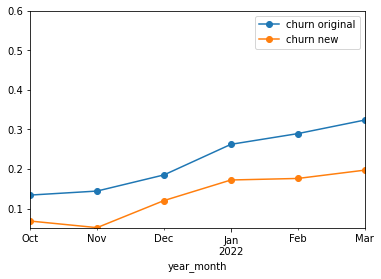

In [63]:
churn_distr[churn_distr['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

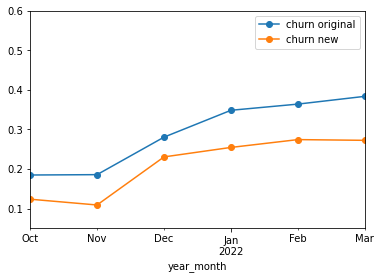

In [64]:
churn_distr[churn_distr['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

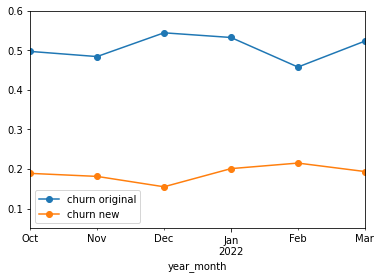

In [65]:
churn_distr[churn_distr['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

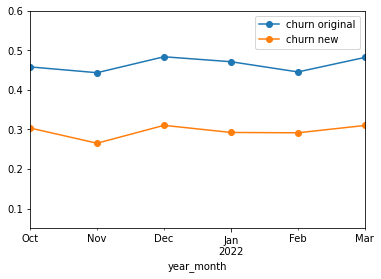

In [66]:
churn_distr[churn_distr['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

# Qualification rate

In [67]:
df_clients = [
'DL',
'DW',
'EMA',
'EMM',
'EMT',
'EMF',
'ST',
'GRG',
'EL',
'VS',
'TT',
'MD',
'DWF',
'GHC',
'SV',
'99HT'
]

In [68]:
churn_joined_client = churn_joined[churn_joined['company_identifier'].isin(df_clients)]

In [69]:
churn_joined_client['diff'] = churn_joined_client['churn_new'] - churn_joined_client['churn_orig']

In [70]:
churn_joined_client['year_month'].unique()

array(['2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [71]:
churn_joined_client[churn_joined_client['year_month'] == '2022-03-01'].sort_values(by = 'diff',ascending = False)

,year_month,churn_orig,company,location,company_identifier,state,churn_new,diff
149,2022-03-01,0.068616,DL,MR283369,DL,MA,0.068624,8.161050e-06
725,2022-03-01,0.010854,TT,C9-0000451-LIC,TT,CA,0.010856,1.774530e-06
317,2022-03-01,0.001482,GRG,C10-0000408-LIC,GRG,CA,0.001482,3.163751e-08
209,2022-03-01,0.000000,EMF,C10-0000939-LIC,EMF,CA,0.000000,0.000000e+00
215,2022-03-01,0.197884,EMM,C10-0000786-LIC,EMM,CA,0.183838,-1.404600e-02
335,2022-03-01,0.136951,GHC,C10-0000414-LIC,GHC,CA,0.114380,-2.257081e-02
131,2022-03-01,0.114284,DWF,402R-00804,DWF,CO,0.091308,-2.297541e-02
203,2022-03-01,0.196748,EMA,C10-0000774-LIC,EMA,CA,0.173692,-2.305608e-02
5,2022-03-01,0.200858,99HT,C10-0000279-LIC,99HT,CA,0.170443,-3.041427e-02
695,2022-03-01,0.170750,DW,MR282376,DW,MA,0.135258,-3.549229e-02


In [116]:
# distribution of margin short for current df clients
churn_distr_short_df = churn_joined_client.groupby(['state','year_month'])['churn_new'].describe().reset_index()
churn_distr_short_df['year_month'] = pd.to_datetime(churn_distr_short_df['year_month'])
churn_distr_short_df.index = churn_distr_short_df.year_month


# distribution of margin orig for current df clients
churn_distr_df = churn_joined_client.groupby(['state','year_month'])['churn_orig'].describe().reset_index()
churn_distr_df['year_month'] = pd.to_datetime(churn_distr_df['year_month'])
churn_distr_df.index = churn_distr_df.year_month



In [134]:
churn_distr_df

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-10-01,CA,2021-10-01,13.0,0.145784,0.137436,0.000000,0.040579,0.115768,0.262152,0.425110
2021-11-01,CA,2021-11-01,13.0,0.149926,0.135177,0.000000,0.038389,0.145397,0.249701,0.417880
2021-12-01,CA,2021-12-01,13.0,0.155007,0.139752,0.000000,0.059869,0.132536,0.257432,0.453042
2022-01-01,CA,2022-01-01,13.0,0.183491,0.137937,0.000000,0.130718,0.178262,0.262408,0.471153
2022-02-01,CA,2022-02-01,13.0,0.184302,0.133291,0.000000,0.128248,0.185062,0.284150,0.456590
2022-03-01,CA,2022-03-01,13.0,0.175830,0.109577,0.000000,0.136951,0.197884,0.239989,0.323832
2021-10-01,CO,2021-10-01,3.0,0.084818,0.081914,0.010993,0.040758,0.070523,0.121731,0.172940
2021-11-01,CO,2021-11-01,3.0,0.115035,0.090347,0.010712,0.088852,0.166993,0.167197,0.167401
2021-12-01,CO,2021-12-01,3.0,0.184811,0.080814,0.117910,0.139917,0.161923,0.218262,0.274601


In [135]:
churn_distr_short_df

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-10-01,CA,2021-10-01,13.0,0.108216,0.121726,0.000000,0.043579,0.103824,0.126352,0.477226
2021-11-01,CA,2021-11-01,13.0,0.113576,0.125563,0.000000,0.038390,0.109120,0.127757,0.483664
2021-12-01,CA,2021-12-01,13.0,0.119830,0.130864,0.000000,0.068619,0.101335,0.144835,0.496036
2022-01-01,CA,2022-01-01,13.0,0.156300,0.137357,0.000000,0.096696,0.137880,0.218054,0.499149
2022-02-01,CA,2022-02-01,13.0,0.152976,0.127456,0.000000,0.109574,0.134550,0.179666,0.480296
2022-03-01,CA,2022-03-01,13.0,0.119326,0.078856,0.000000,0.081383,0.151646,0.170443,0.252814
2021-10-01,CO,2021-10-01,3.0,0.041237,0.025067,0.023836,0.026871,0.029906,0.049938,0.069970
2021-11-01,CO,2021-11-01,3.0,0.047806,0.030315,0.013046,0.037324,0.061602,0.065185,0.068768
2021-12-01,CO,2021-12-01,3.0,0.115976,0.040801,0.068863,0.104091,0.139319,0.139532,0.139745


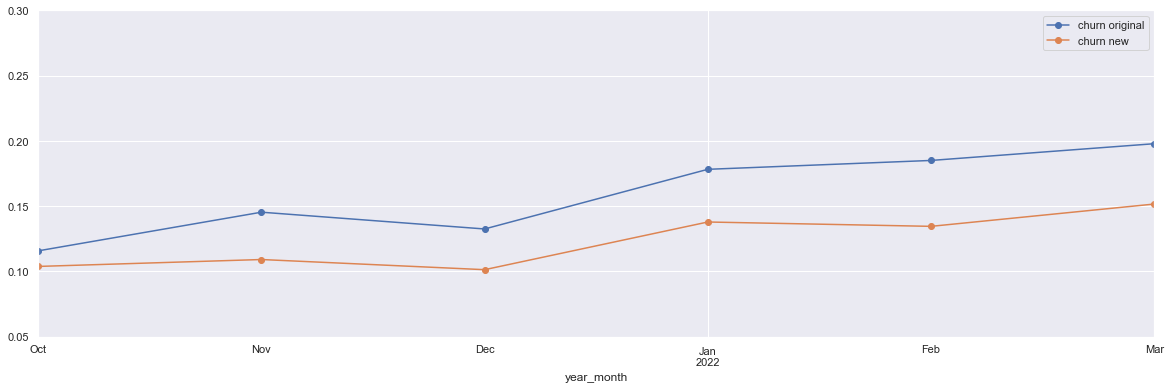

In [130]:
churn_distr_df[churn_distr_df['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn new')

plt.legend()
ax = plt.ylim(0.05,0.3)


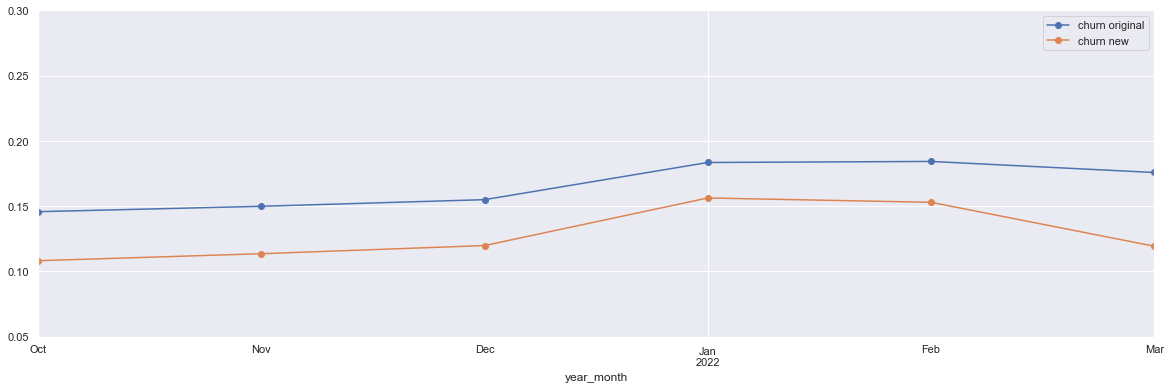

In [131]:
churn_distr_df[churn_distr_df['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.3)

In [119]:
sns.set(rc={'figure.figsize':(20,6)})


Text(0, 0.5, 'margin %')

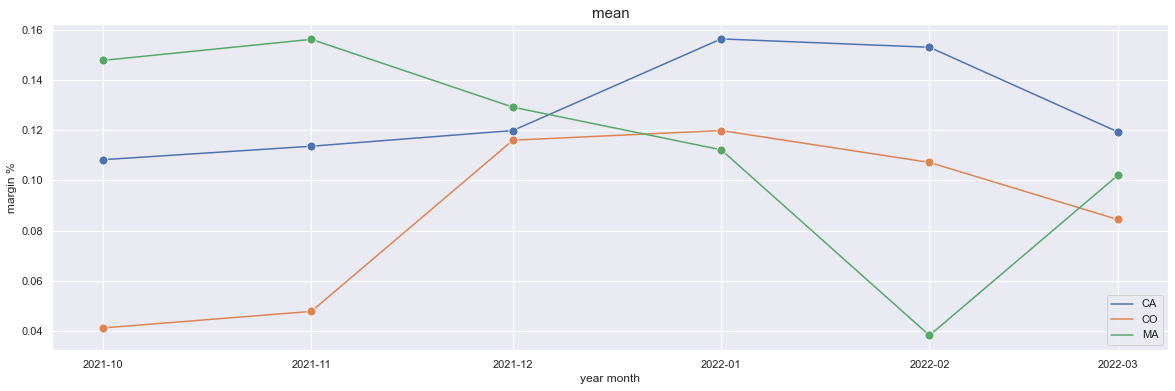

In [120]:

ax = sns.lineplot(data=churn_distr_short_df.reset_index(drop = True), x="year_month", y="mean", hue="state",marker= 'o', markersize=9)

ax.legend(loc = 4)
ax.set_title("mean", fontsize=15)
ax.set_xlabel ("year month")
ax.set_ylabel ("margin %")


In [97]:
churn_distr_short_df

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CA,2021-09-01,13.0,0.061650,0.047954,0.000000,0.026846,0.045704,0.102924,0.134422
2021-10-01,CA,2021-10-01,13.0,0.108216,0.121726,0.000000,0.043579,0.103824,0.126352,0.477226
2021-11-01,CA,2021-11-01,13.0,0.113576,0.125563,0.000000,0.038390,0.109120,0.127757,0.483664
2021-12-01,CA,2021-12-01,13.0,0.119830,0.130864,0.000000,0.068619,0.101335,0.144835,0.496036
2022-01-01,CA,2022-01-01,13.0,0.156300,0.137357,0.000000,0.096696,0.137880,0.218054,0.499149
2022-02-01,CA,2022-02-01,13.0,0.152976,0.127456,0.000000,0.109574,0.134550,0.179666,0.480296
2021-09-01,CO,2021-09-01,3.0,0.052403,0.042075,0.025065,0.028177,0.031290,0.066072,0.100854
2021-10-01,CO,2021-10-01,3.0,0.041237,0.025067,0.023836,0.026871,0.029906,0.049938,0.069970
2021-11-01,CO,2021-11-01,3.0,0.047806,0.030315,0.013046,0.037324,0.061602,0.065185,0.068768


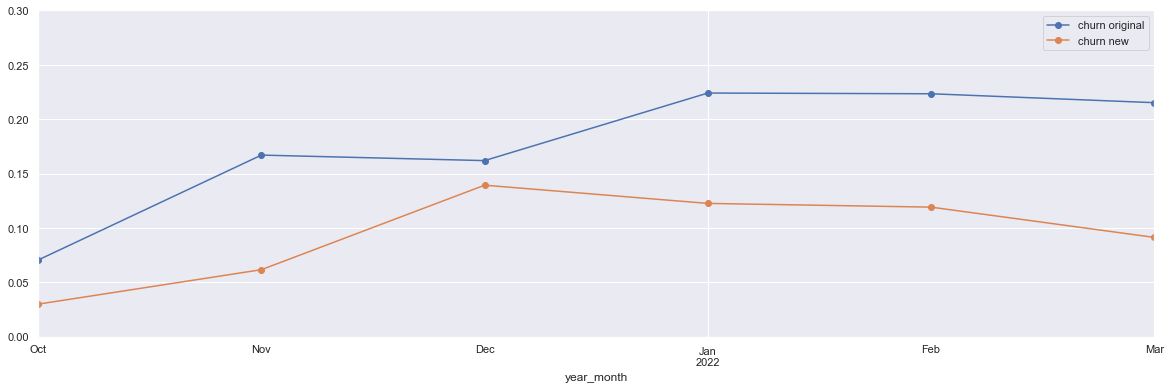

In [124]:
churn_distr_df[churn_distr_df['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0,0.3)

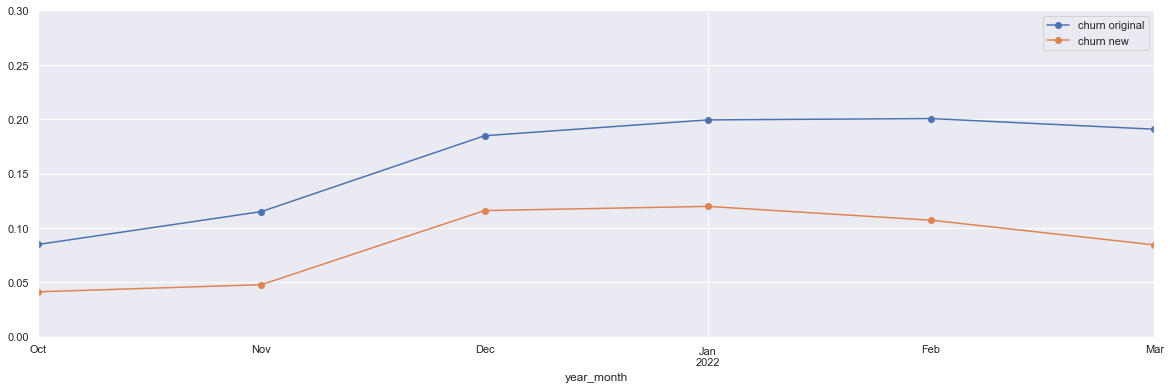

In [125]:
churn_distr_df[churn_distr_df['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0,0.3)

In [90]:
def calculate_monthly_qualification(data):
    q_df = {}
    nq_df = {}
    new_q_df = {}
    new_nq_df = {}
    
    q_2_nq_df = {}
    nq_2_q_df = {}
    for m in ['2021-10-01','2021-11-01',\
             '2021-12-01','2022-01-01','2022-02-01','2022-03-01']:
        
        d = data[data['year_month'] == m]
        qualify_list = d[d['churn_orig'] < 0.45]['company'].unique()
        non_qualify_list = d[d['churn_orig'] >= 0.45]['company'].unique()
        new_qualify_list = d[d['churn_new'] < 0.45]['company'].unique()
        new_non_qualify_list = d[d['churn_new'] >= 0.45]['company'].unique()
        
        q_df[m] = qualify_list
        nq_df[m] = non_qualify_list
        new_q_df[m] = new_qualify_list
        new_nq_df[m] = new_non_qualify_list
        
        q_2_nq = set(qualify_list) - set(new_qualify_list)
        nq_2_q = set(non_qualify_list) - set(new_non_qualify_list)
        
        q_2_nq_df[m] = q_2_nq
        nq_2_q_df[m] = nq_2_q
    return q_df,nq_df,new_q_df,new_nq_df,q_2_nq_df,nq_2_q

In [91]:
q,nq,new_q,new_nq,q_2_nq_data,nq_2_q_data = calculate_monthly_qualification(churn_joined_client)

In [156]:
churn_joined_client[churn_joined_client['company_identifier'] == 'ST']

,year_month,churn_orig,company,location,company_identifier,state,churn_new,diff
684,2021-10-01,0.425110,ST,C9-0000323-LIC,ST,CA,0.477226,0.052115
685,2021-11-01,0.417880,ST,C9-0000323-LIC,ST,CA,0.483664,0.065784
686,2021-12-01,0.453042,ST,C9-0000323-LIC,ST,CA,0.496036,0.042994
687,2022-01-01,0.471153,ST,C9-0000323-LIC,ST,CA,0.499149,0.027997
688,2022-02-01,0.456590,ST,C9-0000323-LIC,ST,CA,0.480296,0.023705
689,2022-03-01,0.187029,ST,C9-0000323-LIC,ST,CA,0.081383,-0.105646


In [92]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in q.items() ])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2021-10-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS
2021-11-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS
2021-12-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-01-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-02-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-03-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS


In [93]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in nq.items() ])).T

,0
2021-10-01,NaN
2021-11-01,NaN
2021-12-01,ST
2022-01-01,ST
2022-02-01,ST
2022-03-01,NaN


In [94]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in new_q.items() ])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2021-10-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2021-11-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2021-12-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-01-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-02-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-03-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS


In [95]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in new_nq.items() ])).T

,0
2021-10-01,ST
2021-11-01,ST
2021-12-01,ST
2022-01-01,ST
2022-02-01,ST
2022-03-01,NaN
